# Notas de la implementación práctica


> Se intentaron bajar 3000 imagenes, bajaron 1860


*Para los modulos propuestos*

Para tener una acercamiento al problema y entender la evolucion de los datos se implemnto primero una par de soluciones no solicitada en la practiva pero que me sirvieron para tener referencias

0.   Modelo de RL
  *   Como referencia y acercamiento al problema

1.   Modelo de imagenes
  *   Se implemento una red propia
  *   Se implemento una red basada en modelo VGG16


2.   Modelo de tabulares
  *   Se implemento una red propia

3.   Modelo fusion
  *   Se implemento late fusion

> Tecnicas y procesos implementados en la practica
  *   EDA normalizacion, escalado, one hot encoding
  *   Dropout
  *   Early stopping
  *   Fine tunning
  


El uso de la GPU y RAM en Colab genero problemas en varias oportunidades lo que dificulto aumentar el entrenamiento, prueba y mejora de los modelos. Con la practica ejecutada en un 80% los recursos de GPU y RAM quedan a tope.

## 1 - Seleccion, carga y visualizzcion del conjunto de datos a trabajar


In [1]:
# Montar el DRIVE de Google para el manejo de los datos.

from google.colab import drive
drive.mount('/content/drive')

# Definiciones para poder usar diferentes conjuntos de datos

# CSV = '/content/drive/MyDrive/filtered_data_100.csv'
# IMAGES = '/content/drive/MyDrive/images_final_100.npy'


# CSV = '/content/drive/MyDrive/filtered_data_allthem.csv'
# IMAGES = '/content/drive/MyDrive/images_final_allthem.npy'

CSV = '/content/drive/MyDrive/filtered_data_3000_1860.csv'
IMAGES = '/content/drive/MyDrive/images_final_3000_1860.npy'



Mounted at /content/drive


In [2]:
## Carga de datos tabulares

import pandas as pd

# Ruta al archivo CSV en Google Drive
csv_file_path = CSV

# Carga el DataFrame
df = pd.read_csv(csv_file_path, sep=';')

# Muestra las primeras filas para verificar
print(df.head())


         ID                            Listing Url       Scrape ID  \
0  15459188  https://www.airbnb.com/rooms/15459188  20170407214050   
1  13184463  https://www.airbnb.com/rooms/13184463  20170407214050   
2  17115175  https://www.airbnb.com/rooms/17115175  20170407214050   
3  15458789  https://www.airbnb.com/rooms/15458789  20170407214050   
4  10378650  https://www.airbnb.com/rooms/10378650  20170407214050   

  Last Scraped                                             Name  \
0   2017-04-08                          Paseo De Gracia I (433)   
1   2017-04-08  Rooftop 2 terraces full of art, style and views   
2   2017-04-08            Flat close to Plaza España - Eixample   
3   2017-04-08                                Paseo de Gracia E   
4   2017-04-08              Sagrada famlia's Sunshine apartment   

                                             Summary  \
0  Unique apartment in vibrant neighborhoods, car...   
1  Our place is  In the cross between Born, Barce...   
2  - Com

In [3]:
df.columns

Index(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary',
       'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview',
       'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url',
       'Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location',
       'Host About', 'Host Response Time', 'Host Response Rate',
       'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url',
       'Host Neighbourhood', 'Host Listings Count',
       'Host Total Listings Count', 'Host Verifications', 'Street',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'City', 'State', 'Zipcode', 'Market',
       'Smart Location', 'Country Code', 'Country', 'Latitude', 'Longitude',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Amenities', 'Square Feet', 'Price', 'Weekly Price',
       'Month

In [4]:
## Carga de imaagenes

import numpy as np

np.random.seed(42)

# Ruta al archivo en Google Drive
npy_file_path = IMAGES

# Carga el array
images = np.load(npy_file_path)

# Verificar el array
print(images.shape)


(1860, 224, 224, 3)


In [5]:
# Filtrar el DataFrame para las columnas de interes segun lo recomendado en la guia del trabajo

columns_of_interest = ['Property Type', 'Room Type', 'Cancellation Policy', 'Accommodates', 'Bathrooms', 'Bedrooms',
                       'Beds', 'Guests Included', 'Extra People', 'Minimum Nights', 'Maximum Nights', 'Number of Reviews',
                       'Host Total Listings Count', 'Price']
df = df[columns_of_interest]

# Verifico las primeras filas para ver que se cargaron los datos
print(df.head())

  Property Type        Room Type Cancellation Policy  Accommodates  Bathrooms  \
0     Apartment  Entire home/apt              strict             4        1.0   
1     Apartment  Entire home/apt            flexible             3        1.5   
2     Apartment     Private room              strict             1        1.0   
3     Apartment  Entire home/apt              strict             4        1.0   
4     Apartment  Entire home/apt              strict             4        1.0   

   Bedrooms  Beds  Guests Included  Extra People  Minimum Nights  \
0       2.0   3.0                1             0               2   
1       1.0   1.0                2            20               1   
2       1.0   1.0                1             0               3   
3       2.0   3.0                1             0               2   
4       2.0   2.0                1            15               1   

   Maximum Nights  Number of Reviews  Host Total Listings Count  Price  
0            1125              

In [6]:
# Obtenemos un resumen estadistico para las variables numéricas
print(df.describe())

       Accommodates    Bathrooms     Bedrooms         Beds  Guests Included  \
count   1860.000000  1852.000000  1856.000000  1851.000000      1860.000000   
mean       3.141398     1.262959     1.329203     1.987034         1.555376   
std        1.992430     0.654511     0.856199     1.570968         1.164588   
min        1.000000     0.000000     0.000000     1.000000         1.000000   
25%        2.000000     1.000000     1.000000     1.000000         1.000000   
50%        2.000000     1.000000     1.000000     1.000000         1.000000   
75%        4.000000     1.000000     2.000000     2.000000         2.000000   
max       16.000000     8.000000    10.000000    16.000000        16.000000   

       Extra People  Minimum Nights  Maximum Nights  Number of Reviews  \
count   1860.000000     1860.000000     1860.000000        1860.000000   
mean       6.901613        2.516129      847.615054          24.134946   
std        8.894244        2.267780      570.640227          39.35

In [7]:
# Cuento la frecuencia de las variables categóricas
for column in ['Property Type', 'Room Type', 'Cancellation Policy']:
    print(df[column].value_counts())
    print("\n")


Apartment          1509
House               157
Condominium          51
Bed & Breakfast      51
Loft                 36
Other                29
Dorm                 10
Chalet                7
Guesthouse            4
Hostel                3
Townhouse             2
Casa particular       1
Name: Property Type, dtype: int64


Entire home/apt    1037
Private room        787
Shared room          36
Name: Room Type, dtype: int64


strict             689
flexible           618
moderate           548
super_strict_60      5
Name: Cancellation Policy, dtype: int64




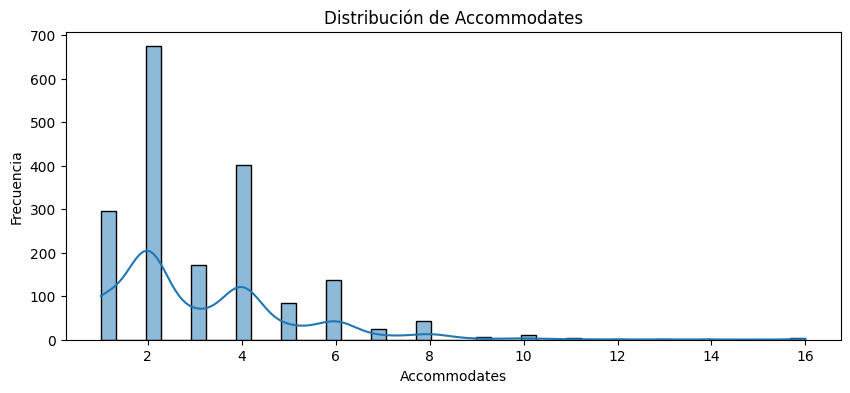

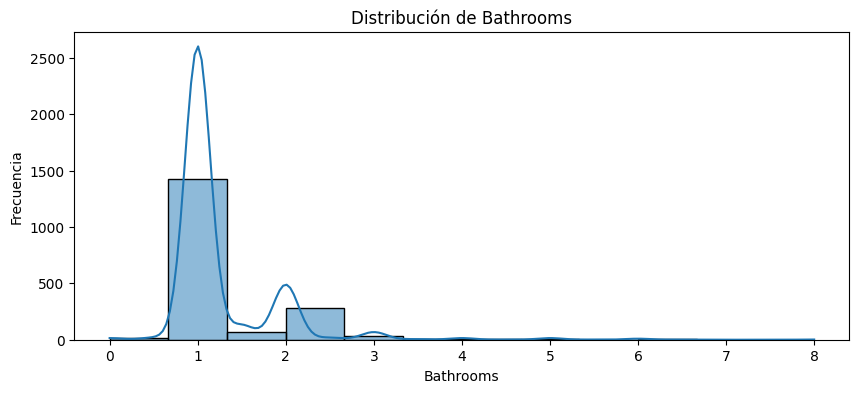

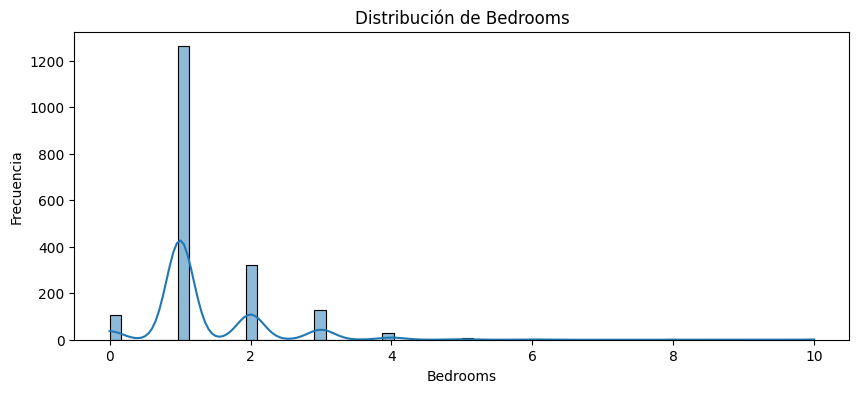

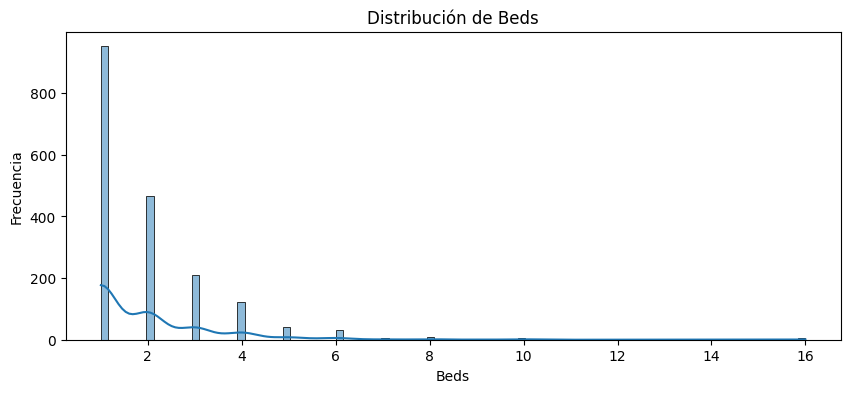

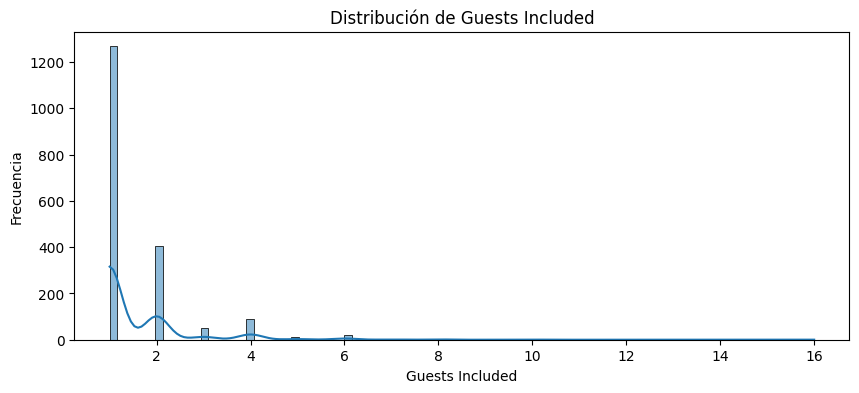

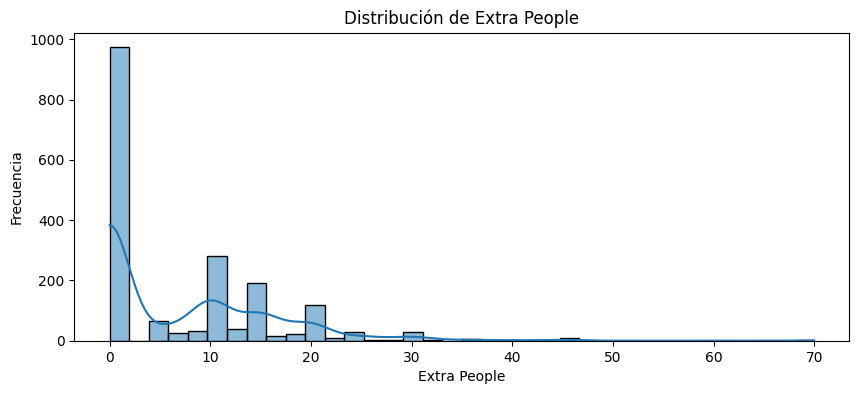

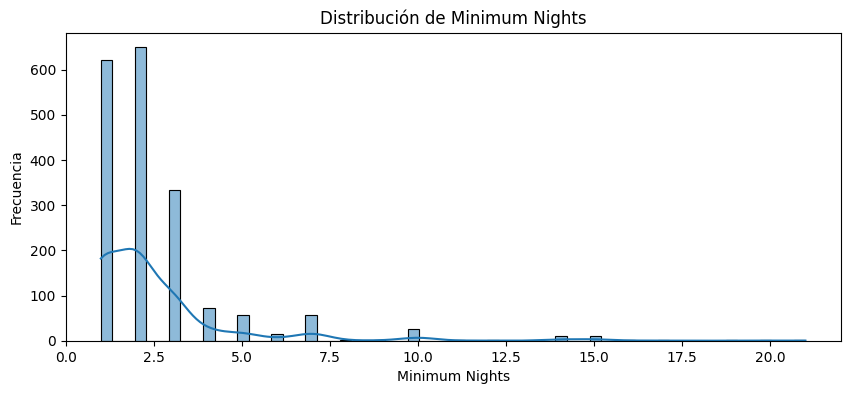

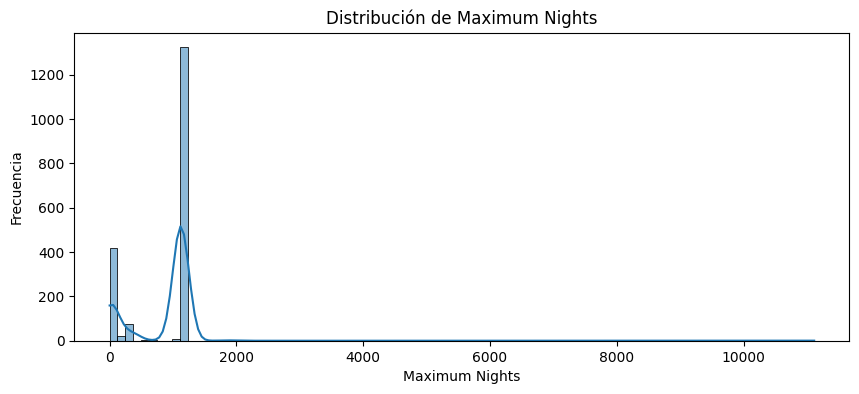

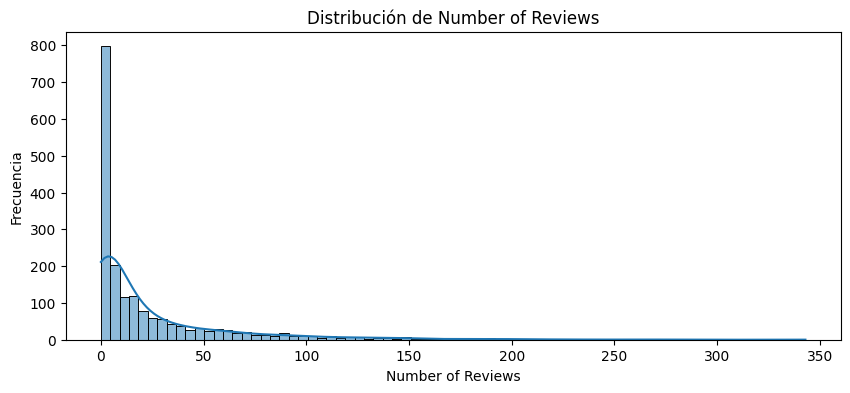

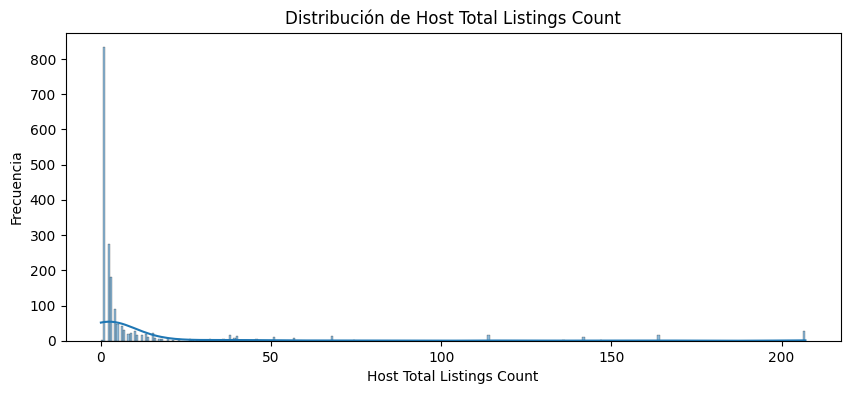

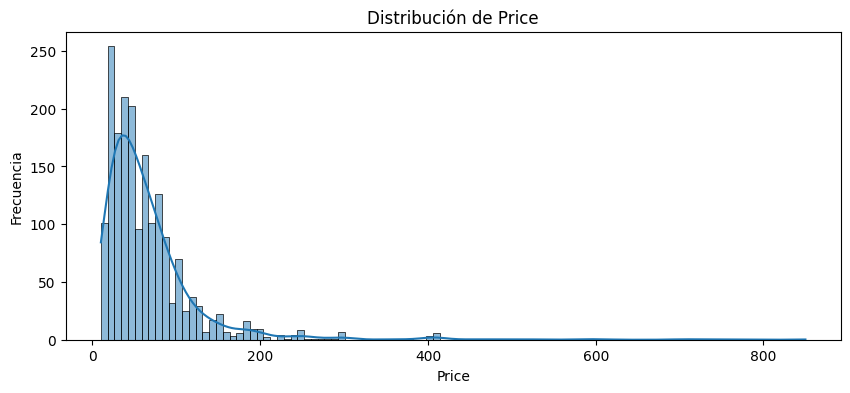

In [8]:
# Distribucion de Variables numericas
import matplotlib.pyplot as plt
import seaborn as sns

# Histogramas para variables numericas
num_columns = ['Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Guests Included', 'Extra People',
               'Minimum Nights', 'Maximum Nights', 'Number of Reviews', 'Host Total Listings Count','Price']

for column in num_columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()


In [9]:
# Conteo de datos faltantes por columna
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])


Bathrooms                    8
Bedrooms                     4
Beds                         9
Host Total Listings Count    1
dtype: int64


<ipython-input-10-6c83bedb1585>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


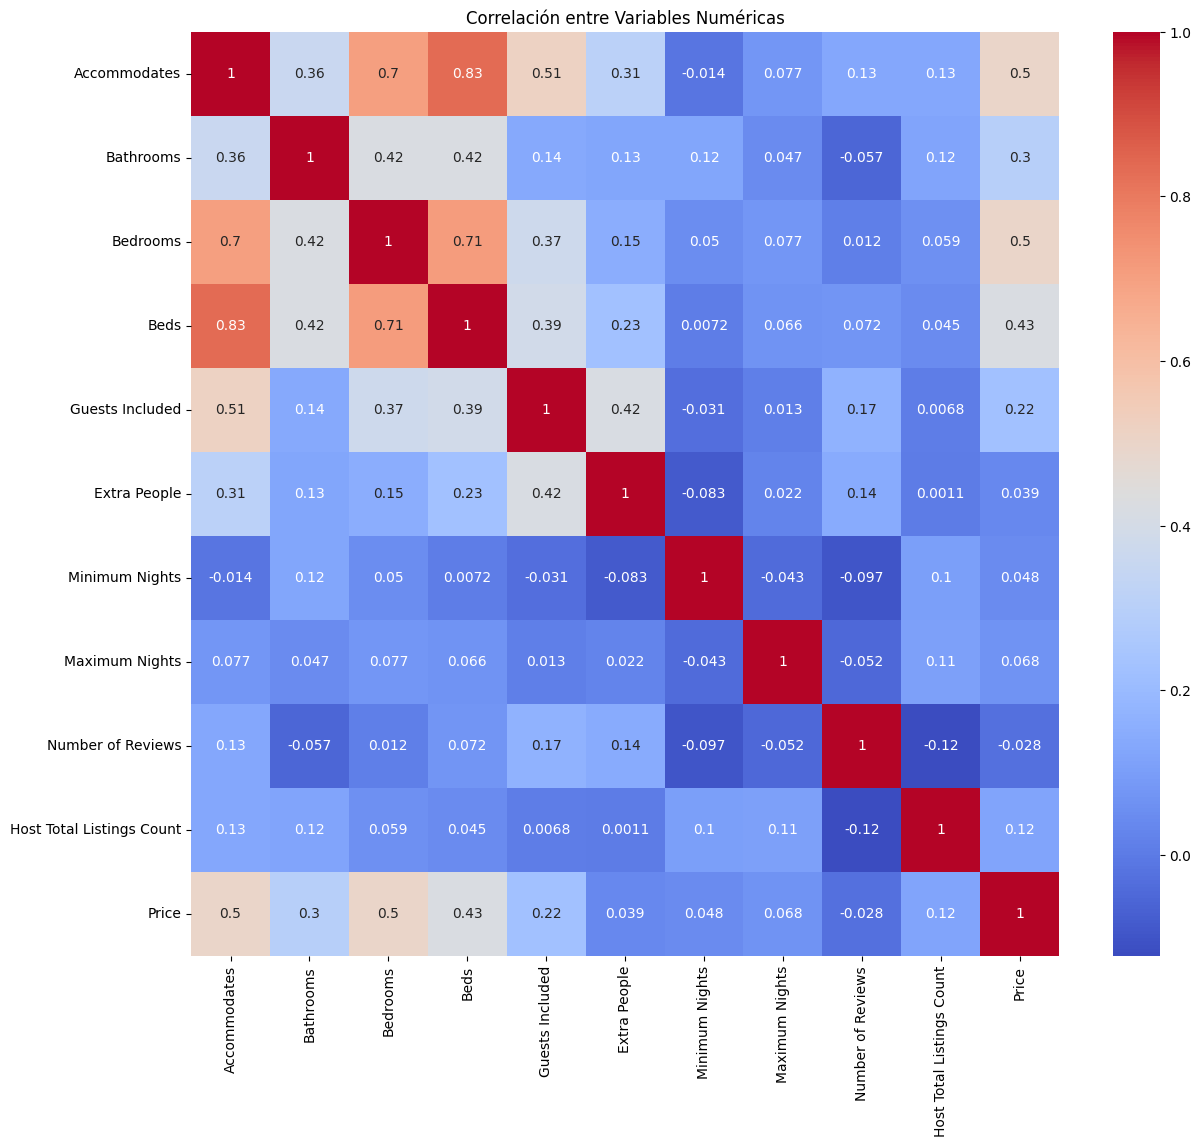

In [10]:
# Calcular la matriz de correlacion
correlation_matrix = df.corr()

# Visualizo la matriz de correlacion
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlación entre Variables Numéricas')
plt.show()


In [11]:
##
## Si bien hay algunas variables con correlación alta, decido no quitarlas porque son didrectamente
## influyentes en el precio. Es razonable que tengan una correlación alta con la variable objetivo
##

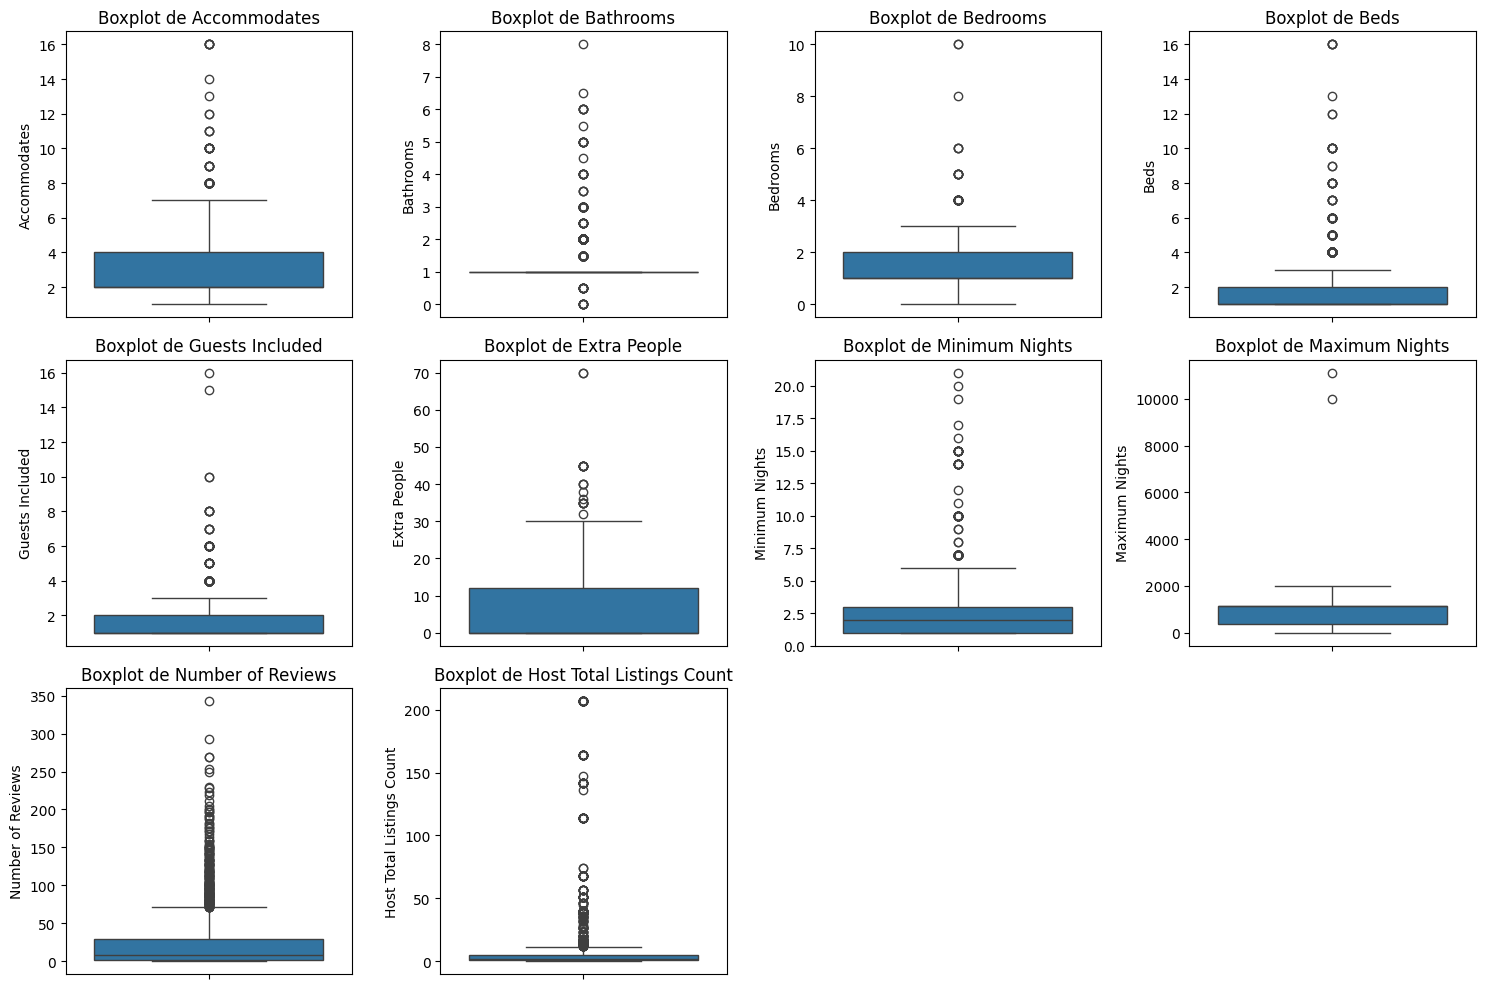

In [12]:
## Analisis de outliers

import matplotlib.pyplot as plt
import seaborn as sns

# Lista de las variables independientes
independent_variables = ['Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Guests Included',
                         'Extra People', 'Minimum Nights', 'Maximum Nights', 'Number of Reviews',
                         'Host Total Listings Count']

# Configurar tamaño para que los boxplots sean legibles
plt.figure(figsize=(15, 10))

# Crea un boxplot para cada variable independiente
for i, column in enumerate(independent_variables):
    plt.subplot(3, 4, i+1)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot de {column}')


plt.tight_layout()
plt.show()



## 2 - Division de los datos

In [13]:
## Division de los datos

from sklearn.model_selection import train_test_split

SEED = 42

## Variables para la division

X_images = images
y_images = df['Price']

X_tab = df.drop('Price', axis=1)  # Independientes
y_tab = df['Price']  # Objetivo


## Datos tabulares

X_tab_train_pre, X_tab_test, y_tab_train_pre, y_tab_test = train_test_split(X_tab, y_tab, test_size=0.2, random_state=SEED)

X_tab_train, X_tab_val, y_tab_train, y_tab_val = train_test_split(X_tab_train_pre, y_tab_train_pre, test_size=0.2, random_state=SEED)

## Datos imagenes

X_images_train_pre, X_images_test, y_images_train_pre, y_images_test = train_test_split(X_images, y_images, test_size=0.2, random_state=SEED)

X_images_train, X_images_val, y_images_train, y_images_val = train_test_split(X_images_train_pre, y_images_train_pre, test_size=0.2, random_state=SEED)



# 3 - Tratamiento de datos

In [14]:
# Imputo valores faltantes con la mediana para no profundizar en el análisis

for column in ['Bathrooms', 'Bedrooms', 'Beds', 'Host Total Listings Count']:
    median_value = X_tab_train[column].median()
    X_tab_train[column].fillna(median_value, inplace=True)
    X_tab_test[column].fillna(median_value, inplace=True)
    X_tab_val[column].fillna(median_value, inplace=True)



In [15]:
# Tratamiento estadistico de outliers
independent_variables = ['Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Guests Included', 'Extra People', 'Minimum Nights', 'Maximum Nights', 'Number of Reviews', 'Host Total Listings Count']

for column in independent_variables:
    Q1 = X_tab_train[column].quantile(0.25)
    Q3 = X_tab_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Ajusto entrenamiento, validacion y test
    X_tab_train[column] = np.where(X_tab_train[column] > upper_bound, upper_bound, X_tab_train[column])
    X_tab_train[column] = np.where(X_tab_train[column] < lower_bound, lower_bound, X_tab_train[column])

    X_tab_val[column] = np.where(X_tab_val[column] > upper_bound, upper_bound, X_tab_val[column])
    X_tab_val[column] = np.where(X_tab_val[column] < lower_bound, lower_bound, X_tab_val[column])

    X_tab_test[column] = np.where(X_tab_test[column] > upper_bound, upper_bound, X_tab_test[column])
    X_tab_test[column] = np.where(X_tab_test[column] < lower_bound, lower_bound, X_tab_test[column])




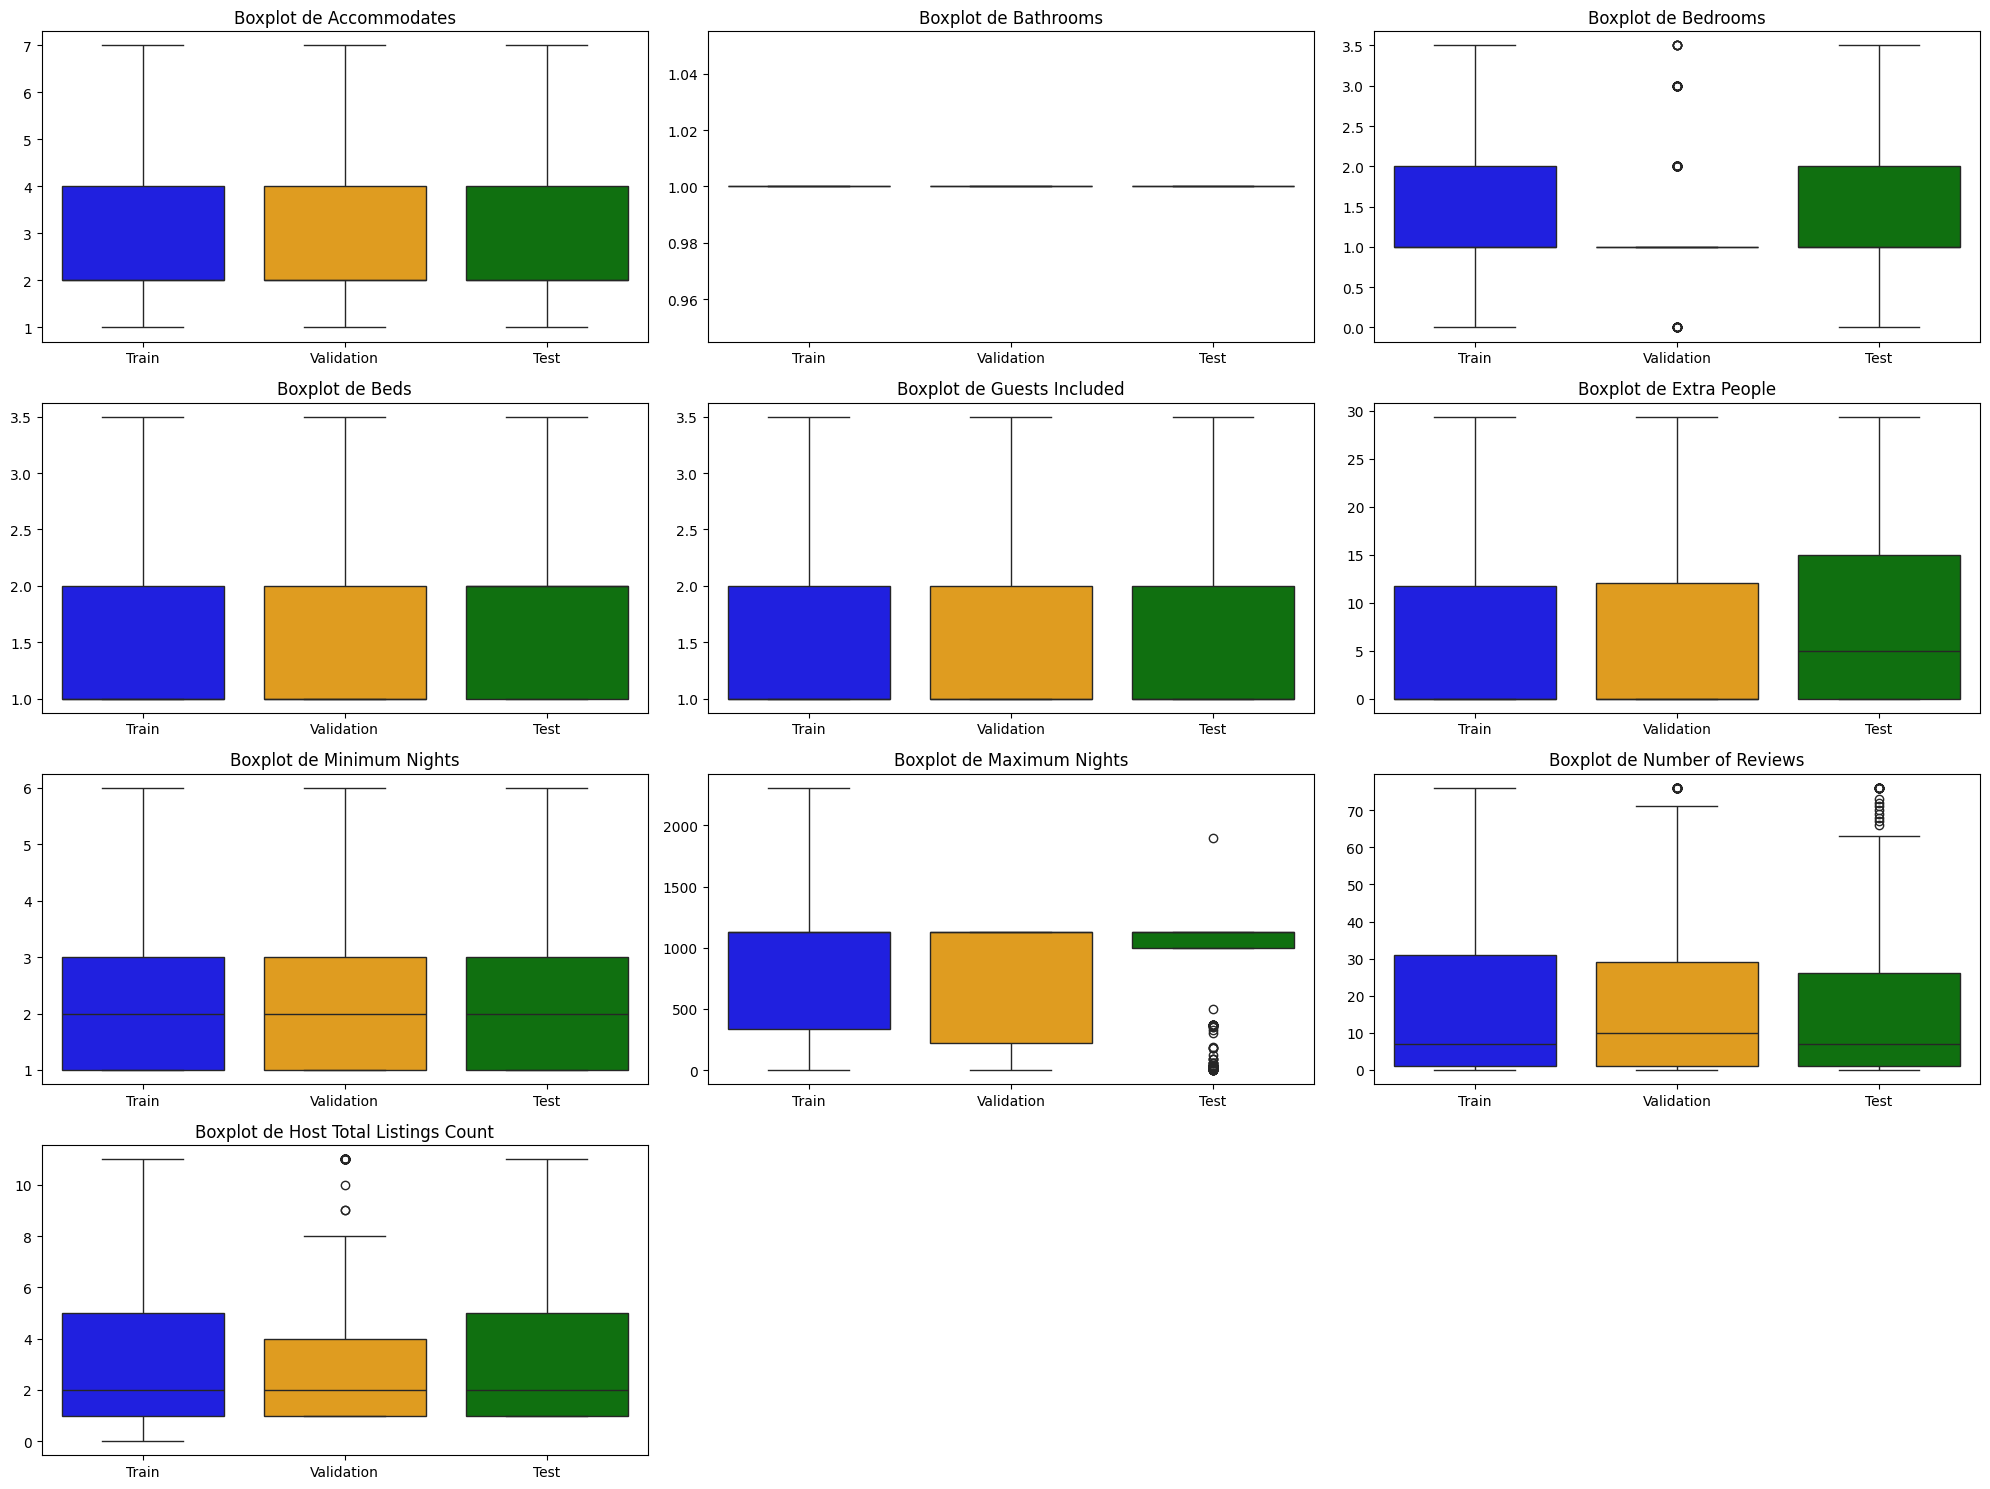

In [16]:
## Visualizacino de outliers luego del tratamiento

import matplotlib.pyplot as plt
import seaborn as sns


independent_variables = ['Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Guests Included',
                         'Extra People', 'Minimum Nights', 'Maximum Nights', 'Number of Reviews',
                         'Host Total Listings Count']

# Configurar tamaño para que los boxplots
plt.figure(figsize=(20, 15))

# Crea un boxplot para cada variable
for i, column in enumerate(independent_variables):
    plt.subplot(len(independent_variables) // 3 + 1, 3, i + 1)

    # Combino los datos en un solo plot para que sea mas facil de comparar
    data_to_plot = pd.concat([
        X_tab_train[column].rename('Train'),
        X_tab_val[column].rename('Validation'),
        X_tab_test[column].rename('Test')
    ], axis=1)

    # Crea el boxplot con colores distintos
    sns.boxplot(data=data_to_plot, palette=['blue', 'orange', 'green'])
    plt.title(f'Boxplot de {column}')

plt.tight_layout()
plt.show()

In [17]:
# Escalado de las caracteristicas numericas

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Ajusto el escaler solo con datos de entrenamiento
scaler.fit_transform(X_tab_train[independent_variables])


# Transformar los conjuntos train, validacion y test
X_tab_val[independent_variables] = scaler.transform(X_tab_val[independent_variables])
X_tab_test[independent_variables] = scaler.transform(X_tab_test[independent_variables])


In [18]:
# Determino las columnas categoricas (de tipo 'object' y 'category')

categorical_columns = df.select_dtypes(include=['object', 'category']).columns

print("Variables categóricas en el DataFrame:")
print(categorical_columns)


Variables categóricas en el DataFrame:
Index(['Property Type', 'Room Type', 'Cancellation Policy'], dtype='object')


In [19]:
#####
#####

# Realizo un backup de los datos por posibles problemas mas adelante

#X_tab_train_bkp = X_tab_train
#X_tab_val_bkp = X_tab_val
#X_tab_test_bkp = X_tab_test

#####
#####

In [20]:
# Transformacin de las variables categoricas

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Columnas categóricas
categorical_features = ['Property Type', 'Room Type', 'Cancellation Policy']


train_categories = {column: X_tab_train[column].unique() for column in categorical_features}

# Creo el transformer de columnas aplicando OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Deja el resto de las columnas no especificadas sin cambios
)

# Ajusto el transofrmer solo para entrenamiento
preprocessor.fit_transform(X_tab_train)

# Transforma los datos
X_tab_train = preprocessor.transform(X_tab_train)
X_tab_val = preprocessor.transform(X_tab_val)
X_tab_test = preprocessor.transform(X_tab_test)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [21]:
# Centramos y normalizamos las imageens (le restamos la media)

X_images_train_mean = np.mean(X_images_train, axis=0)
X_images_train_cent = X_images_train - X_images_train_mean

# Normalizamos
X_images_train_std = np.std(X_images_train, axis=0)
X_images_train = X_images_train_cent / X_images_train_std

X_images_test = (X_images_test - X_images_train_mean) / X_images_train_std
X_images_val = (X_images_val - X_images_train_mean) / X_images_train_std

In [22]:
#####
#####

## Ajusto las variables que estaba usando y mantengo un backup para no tener que reprocesar

# Tabulares
#X_tab_train_pre_bkp = X_tab_train
#X_tab_val_pre_bkp = X_tab_val
#X_tab_test_pre_bkp = X_tab_test

#X_tab_train = X_tab_train_transformed
#X_tab_val = X_tab_val_transformed
#X_tab_test = X_tab_test_transformed

# Imagenes
#X_images_train_norm_bkp = X_images_train_norm
#X_Images_val_norm_bkp =  X_images_val_norm
#X_Images_test_norm_bkp = X_images_test_norm

#X_images_train = X_images_train_norm
#X_Images_val =  X_images_val_norm
#X_Images_test = X_images_test_norm

#####
#####

In [23]:
## Chequeo como quedaron los df.
## X_tab_train_bkp.shape, X_tab_train.shape

# 4 - Modelado
  4.1 Regresion lineal
(para tener referencias del resultado del conjunto)

In [24]:
# Generare una prediccion con una RL para tener una referencia.

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Crear y entrenar el modelo de regresión lineal
model_lr = LinearRegression()
model_lr.fit(X_tab_train, y_tab_train)

# Predecir y evaluar el modelo
y_tab_pred = model_lr.predict(X_tab_test)
mse = mean_squared_error(y_tab_test, y_tab_pred)
mae = mean_absolute_error(y_tab_test, y_tab_pred)

print(f'El Error Cuadratico Medio (MSE) es: {mse} , el Error Absoluto Medio (MAE) es: {mae}')


El Error Cuadratico Medio (MSE) es: 5797.341129906526 , el Error Absoluto Medio (MAE) es: 51.99256528689997


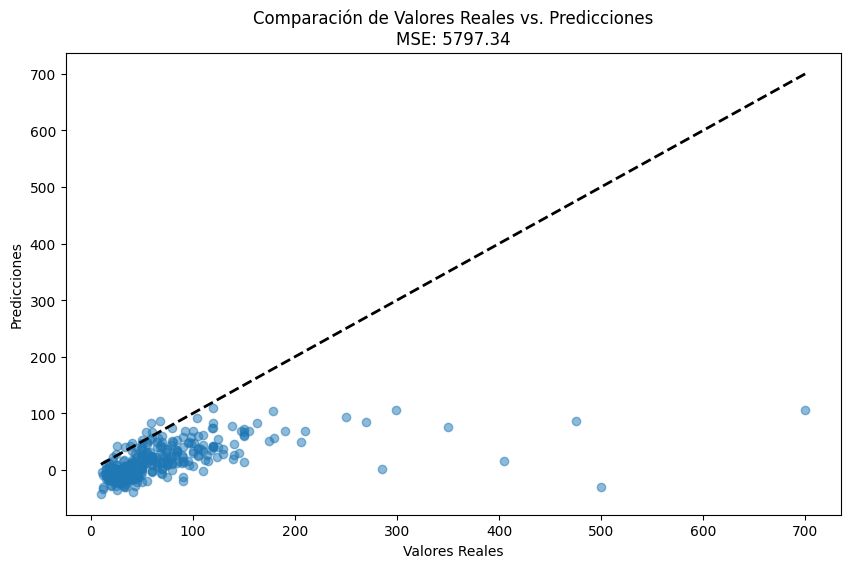

In [25]:
################################################################################
### Visualizacion de la LR
################################################################################

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Calculamos el MSE
mse = mean_squared_error(y_tab_test, y_tab_pred)

# Creamos el gráfico
plt.figure(figsize=(10, 6))
plt.scatter(y_tab_test, y_tab_pred, alpha=0.5)
plt.plot([y_tab_test.min(), y_tab_test.max()], [y_tab_test.min(), y_tab_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title(f'Comparación de Valores Reales vs. Predicciones\nMSE: {mse:.2f}')
plt.show()


# 4.1   Convolucional Basico
Con un modelo de capas convolucionales y maxpooling implementando Dropout




In [26]:
## Desarrollo una primera convolucional como primer acercamiento al problema
##

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Inicializo le modelo
model_images = Sequential()

# Defino capas convolucionales y alterno con maxpooling hasta el clasificador
model_images.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_images.add(MaxPooling2D((2, 2)))
model_images.add(Conv2D(64, (3, 3), activation='relu'))
model_images.add(MaxPooling2D((2, 2)))
model_images.add(Conv2D(128, (3, 3), activation='relu'))
model_images.add(MaxPooling2D((2, 2)))

# Añado el casificador
model_images.add(Flatten())
model_images.add(Dense(128, activation='relu'))
model_images.add(Dropout(0.5))
model_images.add(Dense(1, activation='linear')) # Para regresion

# Defino el learning rate
learning_rate = 0.0001

# Compilacion del modelo
model_images.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate),  metrics=['mae', 'mse'])

# Resumen del modelo
model_images.summary()

# Entrenamiento del modelo
history1 = model_images.fit(X_images_train, y_images_train, epochs=10, batch_size=32, validation_data=(X_images_val, y_images_val ))



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [30]:
history2 = model_images.fit(X_images_train, y_images_train, epochs=20, batch_size=64, validation_data=(X_images_val, y_images_val ))


Epoch 1/20
19/19 [==============================] - 10s 328ms/step - loss: 4103.1079 - mae: 34.9965 - mse: 4103.1079 - val_loss: 4296.6030 - val_mae: 36.7009 - val_mse: 4296.6030
Epoch 2/20
19/19 [==============================] - 2s 110ms/step - loss: 3972.5430 - mae: 34.6773 - mse: 3972.5430 - val_loss: 4371.3564 - val_mae: 38.2028 - val_mse: 4371.3564
Epoch 3/20
19/19 [==============================] - 2s 108ms/step - loss: 3944.9104 - mae: 33.9105 - mse: 3944.9104 - val_loss: 4631.0161 - val_mae: 43.5208 - val_mse: 4631.0161
Epoch 4/20
19/19 [==============================] - 2s 113ms/step - loss: 3834.7810 - mae: 34.9925 - mse: 3834.7810 - val_loss: 4542.8535 - val_mae: 41.7405 - val_mse: 4542.8535
Epoch 5/20
19/19 [==============================] - 2s 111ms/step - loss: 3758.6550 - mae: 34.0492 - mse: 3758.6550 - val_loss: 4382.8618 - val_mae: 38.6207 - val_mse: 4382.8618
Epoch 6/20
19/19 [==============================] - 2s 108ms/step - loss: 3735.9814 - mae: 33.9942 - mse: 373

In [31]:
history3 = model_images.fit(X_images_train, y_images_train, epochs=30, batch_size=128, validation_data=(X_images_val, y_images_val ))

Epoch 1/30
10/10 [==============================] - 8s 251ms/step - loss: 1941.4131 - mae: 28.0466 - mse: 1941.4131 - val_loss: 4538.0044 - val_mae: 37.9906 - val_mse: 4538.0044
Epoch 2/30
10/10 [==============================] - 2s 208ms/step - loss: 1874.5137 - mae: 28.5210 - mse: 1874.5137 - val_loss: 4590.9551 - val_mae: 37.3462 - val_mse: 4590.9551
Epoch 3/30
10/10 [==============================] - 2s 224ms/step - loss: 1849.9153 - mae: 27.9990 - mse: 1849.9153 - val_loss: 4790.2422 - val_mae: 42.5080 - val_mse: 4790.2422
Epoch 4/30
10/10 [==============================] - 2s 217ms/step - loss: 1799.8101 - mae: 28.0243 - mse: 1799.8101 - val_loss: 4776.4575 - val_mae: 41.3819 - val_mse: 4776.4575
Epoch 5/30
10/10 [==============================] - 2s 208ms/step - loss: 1693.3136 - mae: 27.5837 - mse: 1693.3136 - val_loss: 4655.6934 - val_mae: 37.1482 - val_mse: 4655.6934
Epoch 6/30
10/10 [==============================] - 2s 230ms/step - loss: 1574.5712 - mae: 26.7993 - mse: 1574

12/12 [==============================] - 1s 39ms/step - loss: 5575.7925 - mae: 41.8730 - mse: 5575.7925
MSE Pérdida en el conjunto de prueba: 5575.79248046875
MAE en el conjunto de prueba: 41.87300491333008


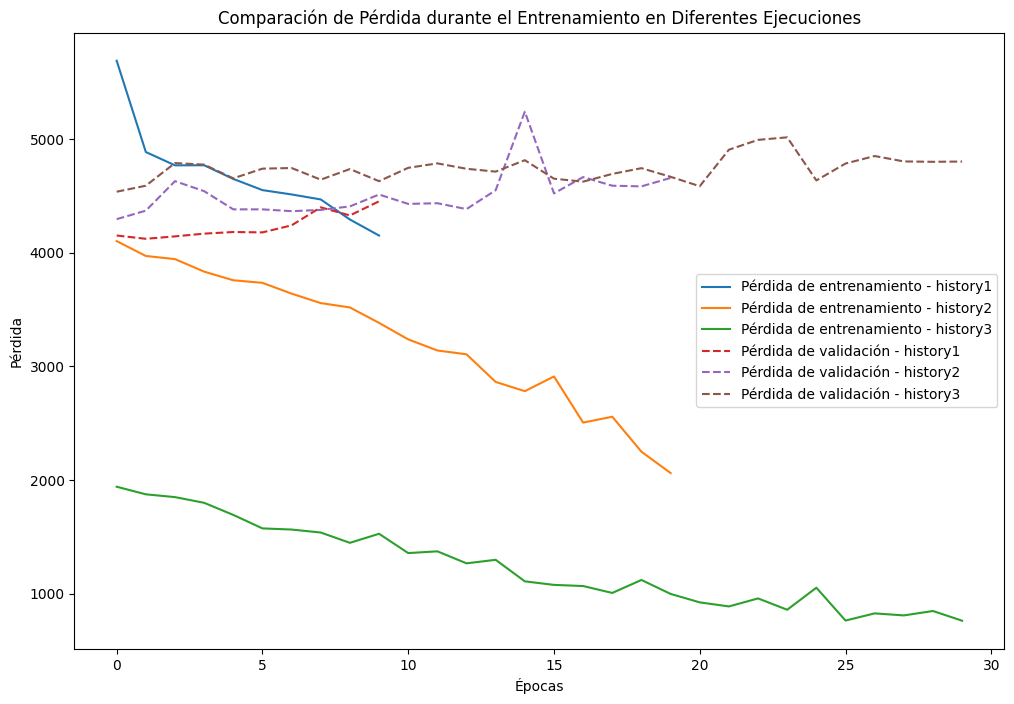

In [36]:
import matplotlib.pyplot as plt

#
#test_loss, test_mae = model_images.evaluate(X_images_test, y_images_test)

test_loss, test_mae, test_mse = model_images.evaluate(X_images_test, y_images_test)
print(f'MSE Pérdida en el conjunto de prueba: {test_loss}')
print(f'MAE en el conjunto de prueba: {test_mae}')

# Visualización de la perdida durante el entrenamiento
plt.figure(figsize=(12, 8))

plt.plot(history1.history['loss'], label='Pérdida de entrenamiento - history1')
plt.plot(history2.history['loss'], label='Pérdida de entrenamiento - history2')
plt.plot(history3.history['loss'], label='Pérdida de entrenamiento - history3')

plt.plot(history1.history['val_loss'], label='Pérdida de validación - history1', linestyle='--')
plt.plot(history2.history['val_loss'], label='Pérdida de validación - history2', linestyle='--')
plt.plot(history3.history['val_loss'], label='Pérdida de validación - history3', linestyle='--')

plt.title('Comparación de Pérdida durante el Entrenamiento en Diferentes Ejecuciones')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


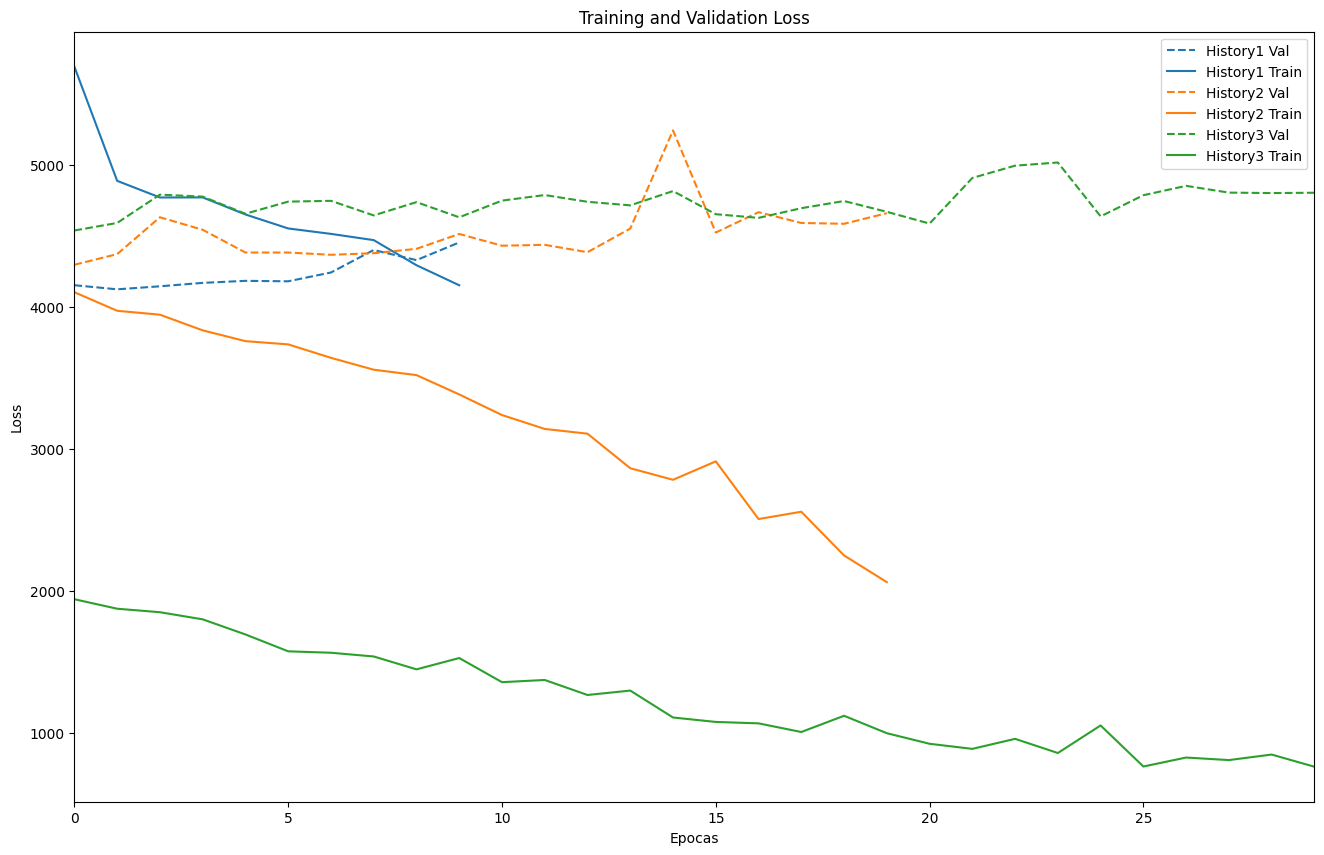

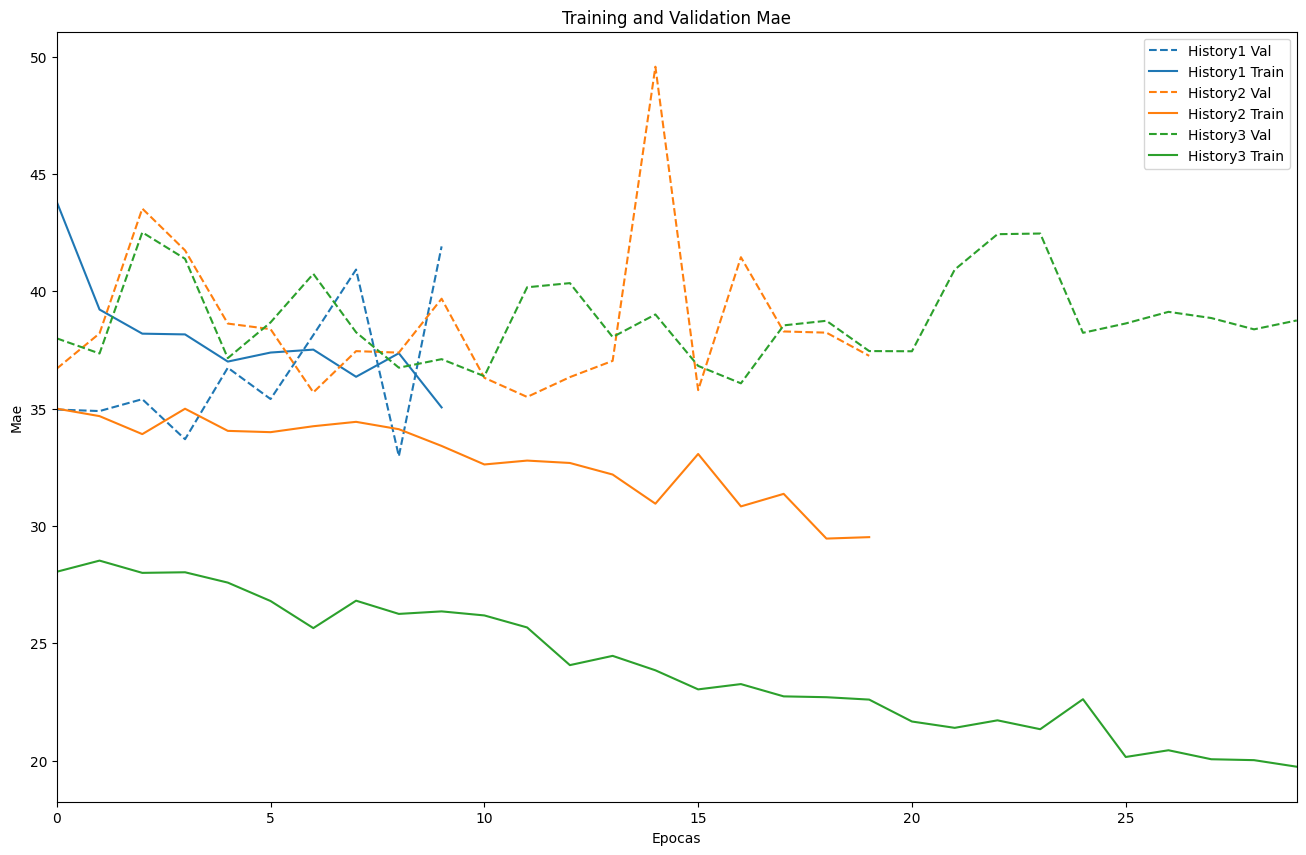

In [33]:
import matplotlib.pyplot as plt

# Funcion para graficar la peérdida y el MAE durante el entrenamiento
def plot_history(histories, key='loss'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epocas')
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])
    plt.title(f'Training and Validation {key.title()}')

# Visualización de la perdida durante el entrenamiento
plot_history([('history1', history1),
              ('history2', history2),
              ('history3', history3)],
              key='loss')

# Visualizacion de MAE durante el entrenamiento
plot_history([('history1', history1),
              ('history2', history2),
              ('history3', history3)],
              key='mae')


12/12 [==============================] - 0s 19ms/step


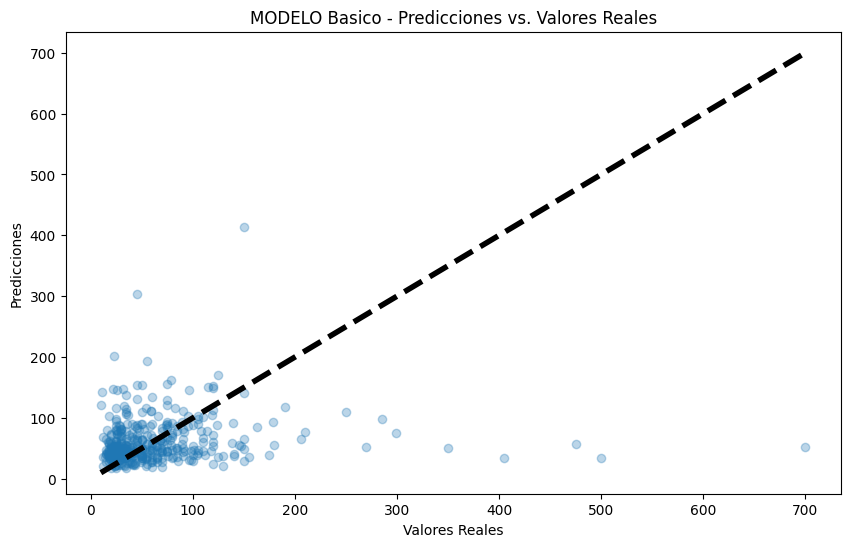

In [38]:
# Grafico la prediccion del modelo Basico

import matplotlib.pyplot as plt

# Obtengo la prediccion del modelo
y_model_images_pred = model_images.predict(X_images_test)

# Gráfico de dispersión de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_images_test, y_model_images_pred, alpha=0.3)  # Corregido para usar y_images_test

# Línea de perfecta predicción
plt.plot([y_images_test.min(), y_images_test.max()], [y_images_test.min(), y_images_test.max()], 'k--', lw=4)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('MODELO Basico - Predicciones vs. Valores Reales')
plt.show()

### **CONCLUSION DE ESTE MODELO**
Con el aumento de epocas se observa uan tendencia hacia la disminucion de la perdida y el error absoluto medio en los datos de entrenamiento. El tamaño del batch influye en el aprendizaje siendo mas lento en batch menores. La perdida de validacion tiene variabilidad a pesar del ajuste de hyperparametros lo cual puede indicar sobre ajuste perdiendo capacidad de generalizar. El modelo esta aprendiento y mejorando con el entrenamiento pero voy a buscar otra arquitectura para buscar un mejor equilibrio en el rendimiento, paraciendo ser para este modelo el entrenamienot en 7 epocas el optimo.


# 4.2   Segunda Convolucional con modelo VGG16
Realizando fine tunning


In [39]:
# Imports necesarios
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Modelo VGG16 sin capas superiores
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelar las capas de la base para no modificar pesos

model_VGG16 = models.Sequential()
model_VGG16.add(base_model)
model_VGG16.add(Flatten())
model_VGG16.add(Dense(256, activation='relu'))
model_VGG16.add(Dropout(0.5))
model_VGG16.add(Dense(1))

# Compilo el modelo con : Error cuadrático medio para regresión y Error absoluto medio para evaluar
model_VGG16.compile(optimizer=Adam(learning_rate=0.001), loss='mse',  metrics=['mae'])

# Resumen del modelo
model_VGG16.summary()

# Entrenamiento del modelo                                                                   # Ver posible ajuste dependiendo de los recursos y tiempo
historyv1 = model_VGG16.fit( X_images_train, y_images_train, batch_size=32, epochs=10, validation_data=(X_images_val, y_images_val))


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21137729 (80.63 MB)
Trainable params: 6423041 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
________

In [40]:
# Despues de entrenar, evaluo el modelo en el conjunto de test

model_VGG16_test_lossv1, model_VGG16_test_maev1 = model_VGG16.evaluate(X_images_test, y_images_test)

print(f"Test Loss: {model_VGG16_test_lossv1}, Test MAE: {model_VGG16_test_maev1}")

12/12 [==============================] - 7s 593ms/step - loss: 4522.3057 - mae: 37.7348
Test Loss: 4522.3056640625, Test MAE: 37.734764099121094


In [43]:
historyv2 = model_VGG16.fit( X_images_train, y_images_train, batch_size=64, epochs=20, validation_data=(X_images_val, y_images_val))

Epoch 1/20
19/19 [==============================] - 20s 444ms/step - loss: 172.5303 - mae: 8.4948 - val_loss: 4173.2378 - val_mae: 37.7867
Epoch 2/20
19/19 [==============================] - 8s 429ms/step - loss: 192.1656 - mae: 8.4169 - val_loss: 4166.3584 - val_mae: 38.7756
Epoch 3/20
19/19 [==============================] - 7s 358ms/step - loss: 215.5197 - mae: 9.7182 - val_loss: 4155.5166 - val_mae: 37.3353
Epoch 4/20
19/19 [==============================] - 7s 360ms/step - loss: 169.9290 - mae: 8.5928 - val_loss: 4138.2549 - val_mae: 36.9519
Epoch 5/20
19/19 [==============================] - 7s 352ms/step - loss: 226.8474 - mae: 9.0532 - val_loss: 4114.8779 - val_mae: 38.0934
Epoch 6/20
19/19 [==============================] - 8s 421ms/step - loss: 190.4568 - mae: 8.6843 - val_loss: 4148.3555 - val_mae: 37.9299
Epoch 7/20
19/19 [==============================] - 8s 411ms/step - loss: 193.4937 - mae: 8.9783 - val_loss: 4178.6030 - val_mae: 36.9501
Epoch 8/20
19/19 [===============

In [42]:
historyv3 = model_VGG16.fit( X_images_train, y_images_train, batch_size=128, epochs=30, validation_data=(X_images_val, y_images_val))

Epoch 1/30
10/10 [==============================] - 47s 3s/step - loss: 545.3578 - mae: 15.0441 - val_loss: 4078.3511 - val_mae: 39.3711
Epoch 2/30
10/10 [==============================] - 8s 830ms/step - loss: 557.0594 - mae: 14.6350 - val_loss: 4077.8025 - val_mae: 37.0200
Epoch 3/30
10/10 [==============================] - 7s 685ms/step - loss: 529.3322 - mae: 14.1362 - val_loss: 4110.9116 - val_mae: 36.9237
Epoch 4/30
10/10 [==============================] - 8s 800ms/step - loss: 443.7106 - mae: 12.7715 - val_loss: 4105.7568 - val_mae: 37.1669
Epoch 5/30
10/10 [==============================] - 8s 810ms/step - loss: 422.7805 - mae: 12.6558 - val_loss: 4130.9282 - val_mae: 37.6228
Epoch 6/30
10/10 [==============================] - 8s 805ms/step - loss: 474.2565 - mae: 12.2159 - val_loss: 4119.8853 - val_mae: 37.9346
Epoch 7/30
10/10 [==============================] - 7s 680ms/step - loss: 389.8550 - mae: 11.4506 - val_loss: 4114.5020 - val_mae: 37.4933
Epoch 8/30
10/10 [===========

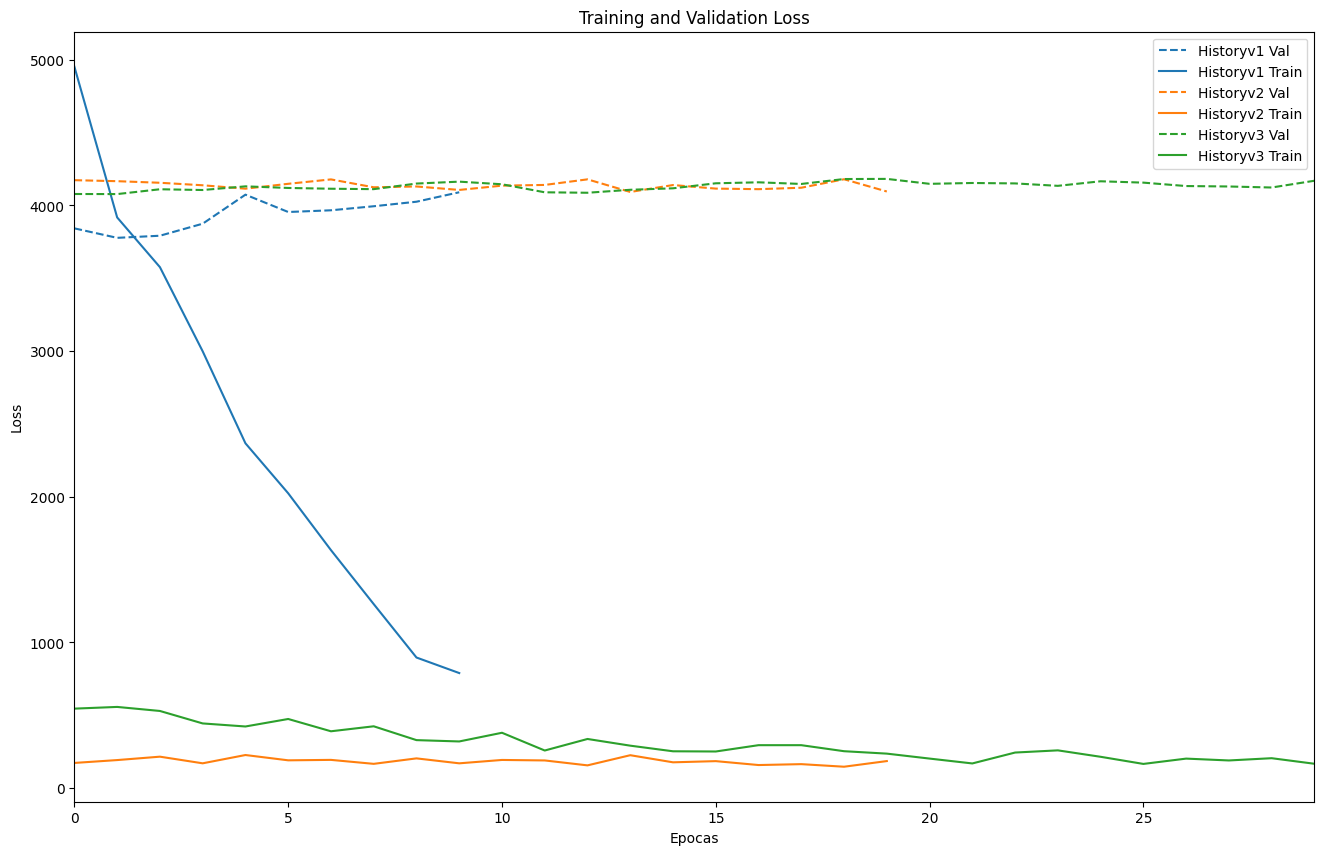

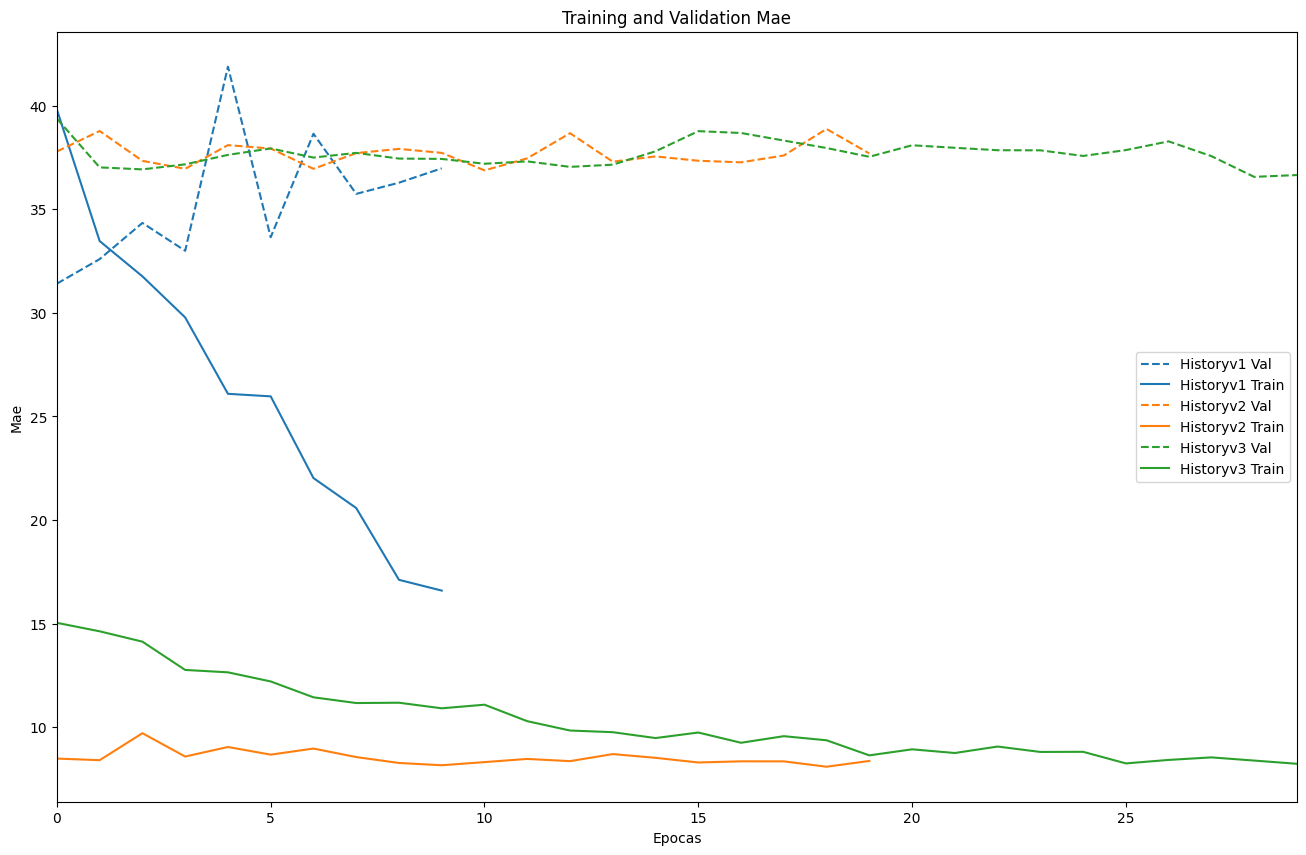

In [44]:
import matplotlib.pyplot as plt

# Funcion para graficar la perdida y el MAE durante el entrenamiento
def plot_history(histories, key='loss'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epocas')
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])
    plt.title(f'Training and Validation {key.title()}')

# Visualización de la perdida durante el entrenamiento
plot_history([('historyv1', historyv1),
              ('historyv2', historyv2),
              ('historyv3', historyv3)],
              key='loss')

# Visualizacion de MAE durante el entrenamiento
plot_history([('historyv1', historyv1),
              ('historyv2', historyv2),
              ('historyv3', historyv3)],
              key='mae')


In [45]:
# Después de entrenar, evaluo el modelo en el conjunto de test

model_VGG16_test_lossv3, model_VGG16_test_maev3 = model_VGG16.evaluate(X_images_test, y_images_test)

print(f"Modelo VGG16 Test Loss V3: {model_VGG16_test_lossv3}, Modelo VGG16 Test MAE V3: {model_VGG16_test_maev3}")

12/12 [==============================] - 2s 128ms/step - loss: 4688.3247 - mae: 38.9858
Modelo VGG16 Test Loss V3: 4688.32470703125, Modelo VGG16 Test MAE V3: 38.98579788208008


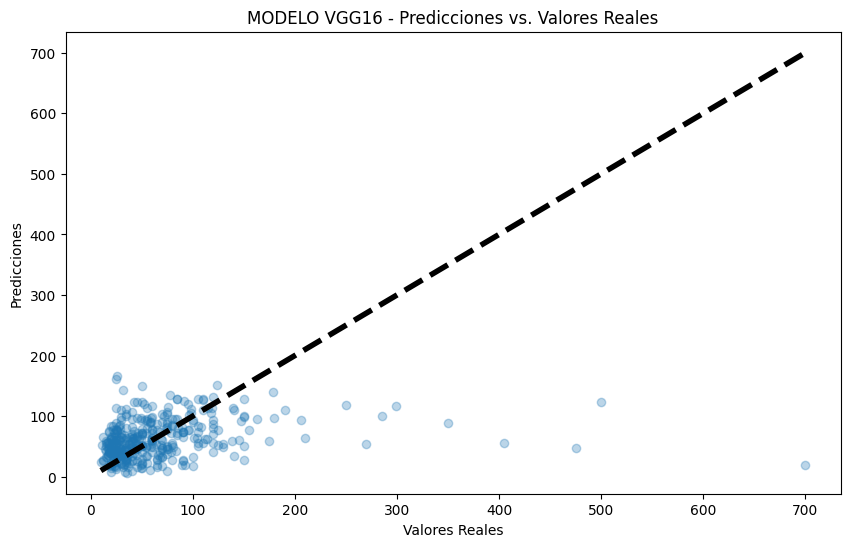

In [ ]:
# Grafico la prediccion del modelo VGG16

import matplotlib.pyplot as plt

# Obtengo la prediccion del modelo
y_VGG16_pred = model_VGG16.predict(X_tab_test)

# Gráfico de dispersión de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_images_test, y_VGG16_pred, alpha=0.3)  # Corregido para usar y_images_test

# Línea de perfecta predicción
plt.plot([y_images_test.min(), y_images_test.max()], [y_images_test.min(), y_images_test.max()], 'k--', lw=4)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('MODELO VGG16 - Predicciones vs. Valores Reales')
plt.show()




### **CONCLUSION DE ESTE MODELO VGG16 **
Con el aumento del entrenamiento se nota una disminucion considerable de la perdida pasando de 549 a 183 lo que indica que el modelo esta aprendiendo y mejorando la capacidad de predecir en entrenamiento. En comparacion con el la ejecucion anterior vemos que la perdida aumento y no hay cambios significativos en el error absoluto. Esto indica que no ha mejorado el rendimienot en los datos de prueba. La falta de mejora sugiere que se requieren ajustes adicionales en learning rate, fine-tunning de algunas capas congeladas de la red, regularizacion, etc.

## 4.3 Convolucional sobre datos tabulares

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Inicializamos el modelo
model_tab = Sequential()

# Definimos las capas densas
model_tab.add(Dense(128, activation='relu', input_shape=(X_tab_train.shape[1],)))
model_tab.add(Dense(128, activation='relu'))
model_tab.add(Dense(64, activation='relu'))
model_tab.add(Dense(32, activation='relu'))
model_tab.add(Dense(1, activation='linear'))

# Compilamos el modelo
model_tab.compile(optimizer='adam', loss='mse', metrics=['mae'])



In [48]:
# Entreno el modelo con Early stopping para evitar overfitting

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_tab.fit(
    X_tab_train, y_tab_train,
    validation_split=0.2,
    epochs=100,
    callbacks=[early_stopping],
    batch_size=32
)


Epoch 1/100
30/30 [==============================] - 2s 12ms/step - loss: 5579.0073 - mae: 48.9464 - val_loss: 6423.8701 - val_mae: 44.9705
Epoch 2/100
30/30 [==============================] - 0s 5ms/step - loss: 5084.7183 - mae: 43.1028 - val_loss: 6134.1851 - val_mae: 42.2646
Epoch 3/100
30/30 [==============================] - 0s 5ms/step - loss: 4724.7837 - mae: 39.9419 - val_loss: 5726.0259 - val_mae: 40.6644
Epoch 4/100
30/30 [==============================] - 0s 5ms/step - loss: 4555.7642 - mae: 38.3404 - val_loss: 6175.6948 - val_mae: 38.5063
Epoch 5/100
30/30 [==============================] - 0s 5ms/step - loss: 4256.9756 - mae: 36.1062 - val_loss: 5367.2544 - val_mae: 39.8890
Epoch 6/100
30/30 [==============================] - 0s 5ms/step - loss: 4124.9126 - mae: 35.4362 - val_loss: 5554.5186 - val_mae: 37.9516
Epoch 7/100
30/30 [==============================] - 0s 5ms/step - loss: 4131.0410 - mae: 36.4467 - val_loss: 5376.9004 - val_mae: 41.1809
Epoch 8/100
30/30 [=======

In [49]:
# Evaluamos el modelo

model_tab_test_loss, model_tab_test_mae = model_tab.evaluate(X_tab_test, y_tab_test)
print(f'Pérdida en el conjunto de prueba: {model_tab_test_loss}')
print(f'MAE en el conjunto de prueba: {model_tab_test_mae}')


12/12 [==============================] - 0s 3ms/step - loss: 5942.0469 - mae: 52.0314
Pérdida en el conjunto de prueba: 5942.046875
MAE en el conjunto de prueba: 52.0313720703125


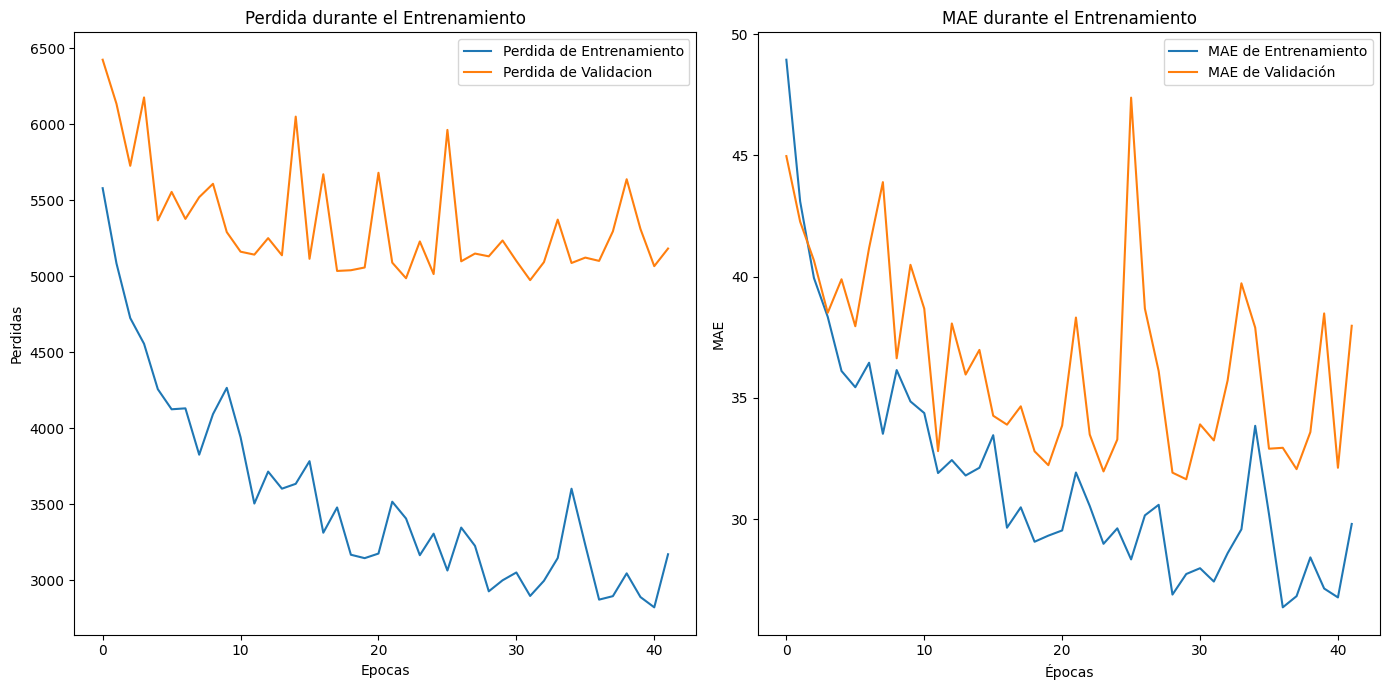

In [50]:
# Visualizo los datos de perdida en entrenamiento y validacion

import matplotlib.pyplot as plt

# Grafica de la perdida
plt.figure(figsize=(14, 7))

# Perdida de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Perdida de Validacion')
plt.title('Perdida durante el Entrenamiento')
plt.xlabel('Epocas')
plt.ylabel('Perdidas')
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE de Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de Validación')
plt.title('MAE durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


12/12 [==============================] - 0s 2ms/step


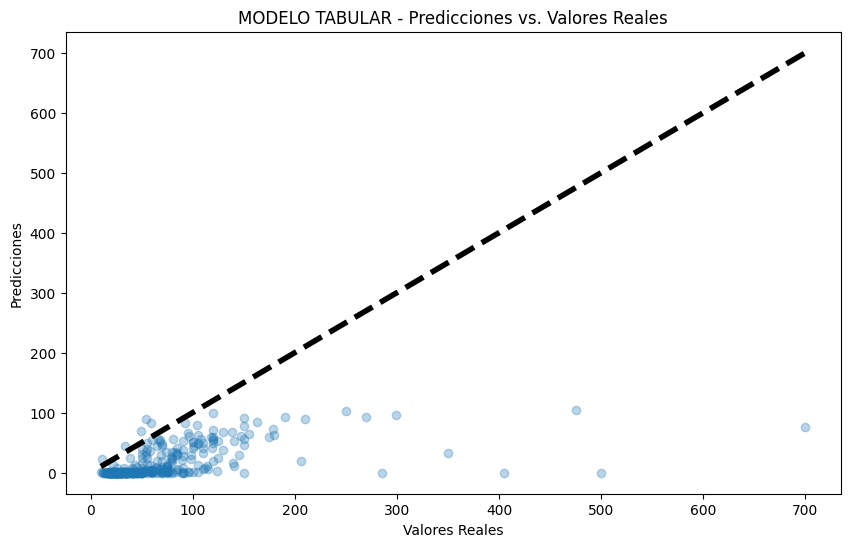

In [51]:
# Grafico la prediccion del modelo TABULAR

import matplotlib.pyplot as plt
import numpy as np

# Predicciones del modelo
y_tab_pred = model_tab.predict(X_tab_test)

# Gráfico de dispersión predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_tab_test, y_tab_pred, alpha=0.3)

# Línea de prediccion
plt.plot([y_tab_test.min(), y_tab_test.max()], [y_tab_test.min(), y_tab_test.max()], 'k--', lw=4)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('MODELO TABULAR - Predicciones vs. Valores Reales')
plt.show()


### **CONCLUSION DE ESTE MODELO VGG16 **
La perdida en el conjunto de train disminuyo en las primera epocas lo cual es indicio de que el modelo aprende, sin embargo la perdida de valicion muestra fluctuaciones y no se consolidad en una tendencia clara, por lo cual el modelo no logra generalizar. La perdida en prueba es considerable, lo que nos indica un error cuadratico importante. La arquitectura del modelo tal vez no sea la mas adecuada y necesite revision

# 5 Combinacion de modelos

In [53]:
# Predicciones del modelo VGG16

y_pred_vgg16_train = model_VGG16.predict(X_images_train)
y_pred_vgg16_val = model_VGG16.predict(X_images_val)

# Predicciones del modelo tabular

y_pred_tab_train = model_tab.predict(X_tab_train)
y_pred_tab_val = model_tab.predict(X_tab_val)

# Predicciones del modelo vgg16 con test

y_pred_vgg16_test = model_VGG16.predict(X_images_test)
y_pred_tab_test = model_tab.predict(X_tab_test)

12/12 [==============================] - 0s 2ms/step


In [55]:
# Sumar prediccion para los conjuntos

import numpy as np

X_combinado_train = np.concatenate([y_pred_vgg16_train, y_pred_tab_train], axis=1)
X_combinado_val = np.concatenate([y_pred_vgg16_val, y_pred_tab_val], axis=1)


X_combinado_test = np.concatenate([y_pred_vgg16_test, y_pred_tab_test], axis=1)


In [56]:
# Entrenar un modelo Random forest

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Entrenar el modelo combinado
model_combinado = RandomForestRegressor(n_estimators=100, random_state=42)
model_combinado.fit(X_combinado_train, y_images_train)

# Evaluar el modelo de fusión en el conjunto de validación
y_combinado_pred_val = model_combinado.predict(X_combinado_val)
combinado_mse_val = mean_squared_error(y_images_val, y_combinado_pred_val)  # Usamos y_images_val porque asumimos que y_tab_val es igual
print(f'MSE del modelo de fusión en validación: {combinado_mse_val}')


y_combinado_pred_test = model_combinado.predict(X_combinado_test)
combinado_mse_test = mean_squared_error(y_images_test, y_combinado_pred_test)  # Idem para test
print(f'MSE del modelo combinado con test: {combinado_mse_test}')


MSE del modelo de fusión en validación: 4023.0009681208053
MSE del modelo combinado con test: 4670.673762096774


In [59]:
# Realizar predicciones en el conjunto de test
y_combinado_pred_test = model_combinado.predict(X_combinado_test)

# Calcular métricas de error, como MAE o MSE, para evaluar el rendimiento
combinado_mse_test = mean_squared_error(y_images_test, y_combinado_pred_test)
combinado_mae_test = mean_absolute_error(y_images_test, y_combinado_pred_test)

print(f'MSE del modelo combinado en el conjunto de test: {combinado_mse_test}')

print(f'MAE del modelo combinado en el conjunto de test: {combinado_mae_test}')

MSE del modelo combinado en el conjunto de test: 4670.673762096774
MAE del modelo combinado en el conjunto de test: 37.42319892473118


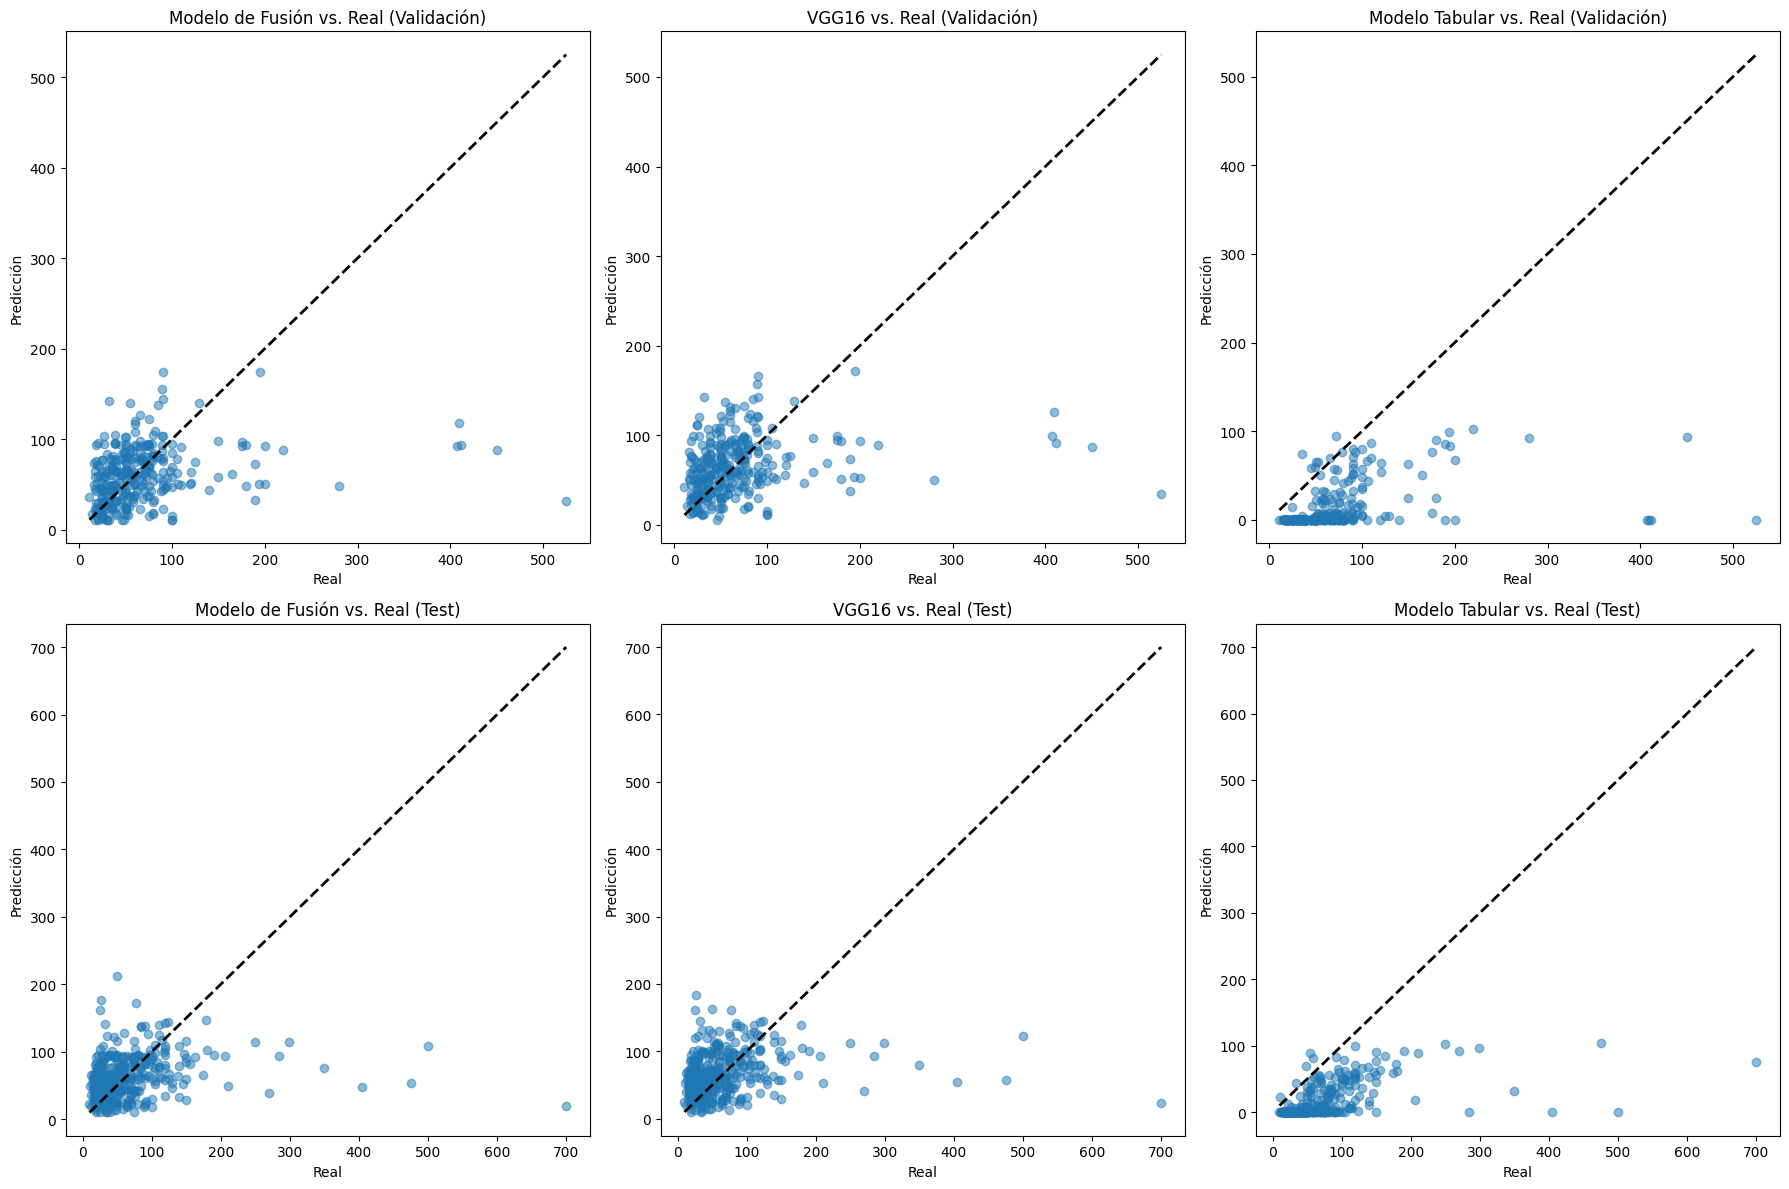

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 12))

# Predicciones en el conjunto de validación

# Modelo de Fusión - Validación
plt.subplot(2, 3, 1)
plt.scatter(y_images_val, y_combinado_pred_val, alpha=0.5)
plt.plot([y_images_val.min(), y_images_val.max()], [y_images_val.min(), y_images_val.max()], 'k--', lw=2)
plt.title('Modelo de Fusión vs. Real (Validación)')
plt.xlabel('Real')
plt.ylabel('Predicción')

# Modelo VGG16 - Validación
plt.subplot(2, 3, 2)
plt.scatter(y_images_val, y_pred_vgg16_val, alpha=0.5)
plt.plot([y_images_val.min(), y_images_val.max()], [y_images_val.min(), y_images_val.max()], 'k--', lw=2)
plt.title('VGG16 vs. Real (Validación)')
plt.xlabel('Real')
plt.ylabel('Predicción')

# Modelo Tabular - Validación
plt.subplot(2, 3, 3)
plt.scatter(y_tab_val, y_pred_tab_val, alpha=0.5)
plt.plot([y_tab_val.min(), y_tab_val.max()], [y_tab_val.min(), y_tab_val.max()], 'k--', lw=2)
plt.title('Modelo Tabular vs. Real (Validación)')
plt.xlabel('Real')
plt.ylabel('Predicción')

# Predicciones en el conjunto de test

# Modelo de Fusión - Test
plt.subplot(2, 3, 4)
plt.scatter(y_images_test, y_combinado_pred_test, alpha=0.5)
plt.plot([y_images_test.min(), y_images_test.max()], [y_images_test.min(), y_images_test.max()], 'k--', lw=2)
plt.title('Modelo de Fusión vs. Real (Test)')
plt.xlabel('Real')
plt.ylabel('Predicción')

# Modelo VGG16 - Test
plt.subplot(2, 3, 5)
plt.scatter(y_images_test, y_pred_vgg16_test, alpha=0.5)
plt.plot([y_images_test.min(), y_images_test.max()], [y_images_test.min(), y_images_test.max()], 'k--', lw=2)
plt.title('VGG16 vs. Real (Test)')
plt.xlabel('Real')
plt.ylabel('Predicción')

# Modelo Tabular - Test
plt.subplot(2, 3, 6)
plt.scatter(y_tab_test, y_pred_tab_test, alpha=0.5)
plt.plot([y_tab_test.min(), y_tab_test.max()], [y_tab_test.min(), y_tab_test.max()], 'k--', lw=2)
plt.title('Modelo Tabular vs. Real (Test)')
plt.xlabel('Real')
plt.ylabel('Predicción')

plt.tight_layout()
plt.show()